![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FWorking+With+Document+AI&dt=Document+AI+-+Process+Responses.ipynb)

# Document AI - Process Responses
> From the [Working With Document AI](https://github.com/statmike/vertex-ai-mlops/blob/main/Working%20With%20Document%20AI/readme.md) series in the [vertex-ai-mlops](https://github.com/statmike/vertex-ai-mlops/blob/main/readme.md) repository.

Document AI is an API where you interact with processors to extract information from documents.  You enable the API, create an instance of a processor in your project, send in document(s), receive back JSON with the extracted information:

<p align="center" width="100%"><center>
    <img src="../architectures/architectures/images/working with/documentai/readme/high_level.png">
</center></p>

---

**Processing**

This workflow covers techniques to extract elements from the responses.  A prior workflow covered all the ways to process a document, or many documents, using Python as the client: [Document AI - Process Documents](./Document%20AI%20-%20Process%20Documents.ipynb). It also shows how to store and retrieve responses from GCS and BigQuery.

---

more here



---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Working%20With%20Document%20AI/Document%20AI%20-%20Process%20Responses.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [9]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.documentai', 'google-cloud-documentai'),
    ('google.cloud.documentai_toolbox', 'google-cloud-documentai-toolbox'),
    ('google.cloud.documentai', 'google-cloud-storage'),
    ('google.cloud.documentai', 'google-cloud-bigquery'),
    ('PIL', 'Pillow'),
    ('PyPDF2', 'PyPDF2')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### API Enablement

In [4]:
!gcloud services enable documentai.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [10]:
REGION = 'us-central1'
SERIES = 'working-with-docai'
EXPERIMENT = 'process-responses'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID

# BigQuery Objects
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE_PREFIX = EXPERIMENT

Packages

In [111]:
import os, io, json

import PyPDF2
import IPython
import PIL, PIL.ImageFont, PIL.Image, PIL.ImageDraw

from google.cloud import documentai
from google.cloud import documentai_toolbox
from google.cloud import storage
from google.cloud import bigquery

Clients

In [12]:
# document AI client
LOCATION = REGION.split('-')[0]
docai = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

# bq client
bq = bigquery.Client(project = PROJECT_ID)

---
## Get The Document

This section prepares a document for processing with online processing.

|Document Name|Link|
|---|---|
|`docs/sports/Baseball - Wikipedia.pdf`|[https://en.wikipedia.org/wiki/Baseball](https://en.wikipedia.org/wiki/Baseball)|

If you are working from a clone of this notebooks repository then the document is already present. The following cell checks for the documents folder, `/docs`, and if it is missing gets the document used in this workflow (`wget`):

In [13]:
file = 'docs/sports/Baseball - Wikipedia.pdf'
if not os.path.exists(file):
    print('Retrieving document...')
    if not os.path.exists(os.path.dirname(file)):
      os.makedirs(os.path.dirname(file))
    import requests, urllib.parse
    r = requests.get(f'https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Working%20With%20Document%20AI/{urllib.parse.quote(file)}')
    open(file, 'wb').write(r.content)
    print(f'Document now at `{file}`')
else:
    print(f'Document Found at `{file}`')

Document Found at `docs/sports/Baseball - Wikipedia.pdf`


---
## Create/Get A Processor

For this workflow we will use the [OCR parser](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-ocr). We can check for an existing processor in the project that the OCR Parser with desired version and if it is not present then create one.  The processor will be connected with Python variable `PARSER` and referred to as a parser as it is used.

Get the type and version from the list of available processors: https://cloud.google.com/document-ai/docs/processors-list

What are the processors already created in this project environment?

In [56]:
processors = list(docai.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'))
len(processors)

4

In [57]:
TYPE = 'OCR_PROCESSOR'
VERSION = 'pretrained-ocr-v2.0-2023-06-02'

Get an existing processor:

In [58]:
PARSER = ''
for processor in processors:
    if processor.type_ == TYPE and processor.default_processor_version.split('/')[-1] == VERSION:
        PARSER = processor
        break
        
if PARSER:
    print(f'There is an existing processor with the desire type and version in PARSER = {PARSER.display_name}')
else:
    print(f'Need to create a processor for the desired type and version: {TYPE}, {VERSION}')

There is an existing processor with the desire type and version in PARSER = working-with-docai


Create the processor if an existing one was not found to match:

In [59]:
if not PARSER:
    PARSER = docai.create_processor(
        parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
        processor = documentai.Processor(
            display_name = SERIES,
            type_ = TYPE
        )
    )
    set_default = docai.set_default_processor_version(
        request = documentai.SetDefaultProcessorVersionRequest(
            processor = PARSER.name,
            default_processor_version = f'{PARSER.name}/processorVersions/{VERSION}'
        )
    )
    set_default.result()
    PARSER = docai.get_processor(
        name = PARSER.name
    )
    print(f'Processor created and in PARSER variable with display name = {PARSER.display_name}')

---
## Online Processing (single document)

There are three ways to provide a single document to the client and each is covered in this section.

> NOTE: The [OCR Processor](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-ocr) has pages limits of 15 for online, and 500 for batch processing.

The following is the Python client reference to use for this online processing section:
- [google.cloud.documentai.DocumentProcessorServiceClient.process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)

Using the processor stored in `PARSER` from above:

In [60]:
PARSER.name

'projects/1026793852137/locations/us/processors/d59e19cc08278630'

Read the document to a bytes object:

In [61]:
with open(file, 'rb') as f:
    local_doc = f.read()

In [62]:
type(local_doc)

bytes

---
### Document as bytes: `inline_document`

Reference:
- [documentai.ProcessRequest()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessRequest)
    - (This One) `inline_document` = [documentai.Document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)
    - `raw_document` = [documentai.RawDocument()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.RawDocument)
    - `gcs_document` = [documentai.GcsDocument()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.GcsDocument)

In [195]:
response = docai.process_document(
    request = documentai.ProcessRequest(
        name = PARSER.name,
        inline_document = documentai.Document(
            content = local_doc,
            mime_type = 'application/pdf'
        ),
        process_options = documentai.ProcessOptions(
            from_start = 5,
            ocr_config = documentai.OcrConfig(
                enable_symbol = True,
                enable_image_quality_scores = True,
                premium_features = documentai.OcrConfig.PremiumFeatures(
                    compute_style_info = True
                )
            )
        )
    )
)

In [196]:
len(response.document.pages)

5

In [197]:
print(response.document.text[0:250])

10/27/23, 9:22 AM
Baseball - Wikipedia
WIKIPEDIA
The Free Encyclopedia
Toggle the table of contents
Baseball
✰ B
ETTS
Baseball is a bat-and-ball sport played between two
Baseball
teams of nine players each, taking turns batting and
fielding. The game


---
## Extraction: Python

The response from online processing is a [`documentai.ProcessResponse()`](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse) which has a `document` attributed which is a [`documentai.Document()`](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document) protobuf.  This object can be directly used to extract elements of the document.  It can also be converted to other data types that can be iterated in Python:
- JSON with `response.document.to_json()`
- Dictionary with `response.document.to_dict()`
- > Note: These follow the `google.protobuf.json_format` - [reference](https://googleapis.dev/python/protobuf/latest/google/protobuf/json_format.html).  That means the parameters of `.to_dict()` are the same as `google.protobuf.json_format.MessageToDict()` which includes `use_integer_for_enums` which should be set `= False` to get the text representation of enum values.

The workflow has a helpful guide to the structure of the `documentai.Document` object in the [readme.md](./readme.md).

In [198]:
response.document.mime_type

'application/pdf'

### OCR Text: document.text

In [199]:
print(response.document.text[0:500])

10/27/23, 9:22 AM
Baseball - Wikipedia
WIKIPEDIA
The Free Encyclopedia
Toggle the table of contents
Baseball
✰ B
ETTS
Baseball is a bat-and-ball sport played between two
Baseball
teams of nine players each, taking turns batting and
fielding. The game occurs over the course of several
plays, with each play generally beginning when a player
on the fielding team, called the pitcher, throws a ball
that a player on the batting team, called the batter, tries
to hit with a bat. The objective of the off


### Pages

`response.document.pages` = list of [documentai.Document.Page](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page)

How many pages?

In [200]:
len(response.document.pages)

5

Pick a single page, the first one:

In [201]:
page = response.document.pages[0]

In [202]:
page.page_number

1

What are the physical characteristics of the page? Layout and size (in pixels)?
- [documentai.Document.Page.Dimension()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Dimension)
- [documentai.Document.Page.Layout()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Layout)

In [203]:
page.dimension

width: 1758.0
height: 2275.0
unit: "pixels"

In [204]:
page.layout

text_anchor {
  text_segments {
    end_index: 2703
  }
}
bounding_poly {
  vertices {
  }
  vertices {
    x: 1758
  }
  vertices {
    x: 1758
    y: 2275
  }
  vertices {
    y: 2275
  }
  normalized_vertices {
  }
  normalized_vertices {
    x: 1.0
  }
  normalized_vertices {
    x: 1.0
    y: 1.0
  }
  normalized_vertices {
    y: 1.0
  }
}
orientation: PAGE_UP

What languages are used within the pages text?
- [documenai.Document.Page.DetectedLanguage()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.DetectedLanguage)

In [205]:
page.detected_languages

[language_code: "en"
confidence: 0.9778176546096802
, language_code: "und"
confidence: 0.022182323038578033
]

What is the text on the page?

Use the pages `text_anchor` and `text_segments` list to get the range of characters from `response.document.text` that contain the pages text.  When the `start_index` is missing from `text_anchor` is means start at 0.

In [206]:
print(response.document.text[0:page.layout.text_anchor.text_segments[0].end_index])

10/27/23, 9:22 AM
Baseball - Wikipedia
WIKIPEDIA
The Free Encyclopedia
Toggle the table of contents
Baseball
✰ B
ETTS
Baseball is a bat-and-ball sport played between two
Baseball
teams of nine players each, taking turns batting and
fielding. The game occurs over the course of several
plays, with each play generally beginning when a player
on the fielding team, called the pitcher, throws a ball
that a player on the batting team, called the batter, tries
to hit with a bat. The objective of the offensive team
(batting team) is to hit the ball into the field of play,
away from the other team's players, allowing its players
to run the bases, having them advance counter-
clockwise around four bases to score what are called
"runs". The objective of the defensive team (referred to
as the fielding team) is to prevent batters from
becoming runners, and to prevent runners' advance
around the bases. [2] A run is scored when a runner
Boston Red Sox player Mookie Betts hits a
legally advances around

What does the page look like?
- [documentai.Document.Page.Image()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Image)

In [207]:
page.image.width, page.image.height, page.image.mime_type

(1758, 2275, 'image/png')

In [208]:
type(page.image.content)

bytes

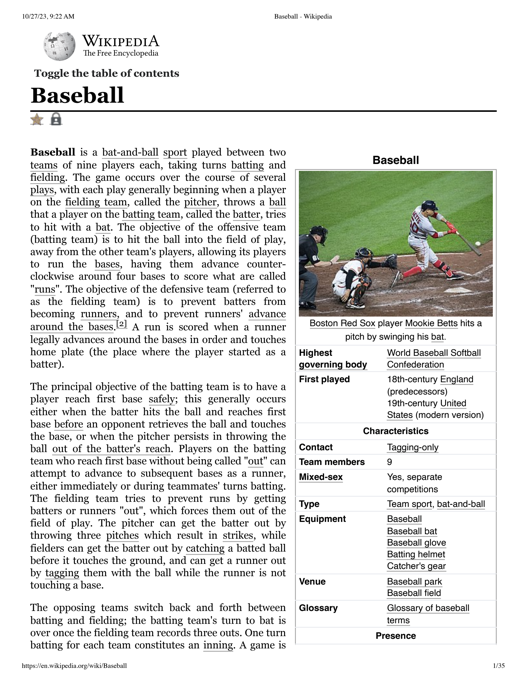

In [209]:
IPython.display.display(
    PIL.Image.open(
        io.BytesIO(page.image.content)
    ).resize(
        (int(.3 * page.image.width), int(.3 * page.image.height))
    )
)

What is the quality of the pages image?
- [documentai.Document.Page.ImageQualityScores](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.ImageQualityScores)

In [210]:
page.image_quality_scores

quality_score: 0.9518429040908813
detected_defects {
  type_: "quality/defect_document_cutoff"
  confidence: 1.0
}
detected_defects {
  type_: "quality/defect_glare"
  confidence: 0.635657012462616
}
detected_defects {
  type_: "quality/defect_text_cutoff"
  confidence: 0.5
}

In [211]:
page.detected_barcodes

[]

In [212]:
page.visual_elements

[]

In [213]:
page.tables

[]

In [215]:
page.form_fields

[]

### Pages:Blocks

- [documentai.Document.Page.Block](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Block)

In [216]:
def extractor(component):
    
    components = []
    
    for part in component:
        components.append(
            "".join(
                [
                    response.document.text[segment.start_index:segment.end_index] for segment in part.layout.text_anchor.text_segments
                ]
            )
        )
    
    return components

In [217]:
blocks = extractor(page.blocks)

In [218]:
for p, part in enumerate(blocks):
    print(f'{p} -------------------------------------------------------------------:\n{part}')

0 -------------------------------------------------------------------:
10/27/23, 9:22 AM

1 -------------------------------------------------------------------:
Baseball - Wikipedia

2 -------------------------------------------------------------------:
WIKIPEDIA
The Free Encyclopedia

3 -------------------------------------------------------------------:
Toggle the table of contents

4 -------------------------------------------------------------------:
Baseball

5 -------------------------------------------------------------------:
✰ B

6 -------------------------------------------------------------------:
ETTS

7 -------------------------------------------------------------------:
Baseball is a bat-and-ball sport played between two
Baseball
teams of nine players each, taking turns batting and
fielding. The game occurs over the course of several
plays, with each play generally beginning when a player
on the fielding team, called the pitcher, throws a ball
that a player on the batting

### Pages:Paragraphs

- [documentai.Document.Page.Paragraph](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Paragraph)

In [219]:
paragraphs = extractor(page.paragraphs)

In [220]:
for p, part in enumerate(paragraphs):
    print(f'{p} -------------------------------------------------------------------:\n{part}')

0 -------------------------------------------------------------------:
10/27/23, 9:22 AM

1 -------------------------------------------------------------------:
Baseball - Wikipedia

2 -------------------------------------------------------------------:
WIKIPEDIA
The Free Encyclopedia

3 -------------------------------------------------------------------:
Toggle the table of contents

4 -------------------------------------------------------------------:
Baseball

5 -------------------------------------------------------------------:
✰ B

6 -------------------------------------------------------------------:
ETTS

7 -------------------------------------------------------------------:
Baseball is a bat-and-ball sport played between two
Baseball
teams of nine players each, taking turns batting and
fielding. The game occurs over the course of several
plays, with each play generally beginning when a player
on the fielding team, called the pitcher, throws a ball
that a player on the batting

### Pages:Lines

- [documentai.Document.Page.Line](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Line)

In [221]:
lines = extractor(page.lines)

In [222]:
for p, part in enumerate(lines):
    print(f'{p} --------------------------------------: {part}')

0 --------------------------------------: 10/27/23, 9:22 AM

1 --------------------------------------: Baseball - Wikipedia

2 --------------------------------------: WIKIPEDIA

3 --------------------------------------: The Free Encyclopedia

4 --------------------------------------: Toggle the table of contents

5 --------------------------------------: Baseball

6 --------------------------------------: ✰ B

7 --------------------------------------: ETTS

8 --------------------------------------: Baseball is a bat-and-ball sport played between two

9 --------------------------------------: Baseball

10 --------------------------------------: teams of nine players each, taking turns batting and

11 --------------------------------------: fielding. The game occurs over the course of several

12 --------------------------------------: plays, with each play generally beginning when a player

13 --------------------------------------: on the fielding team, called the pitcher, throws a bal

### Pages:Tokens

- [documentai.Document.Page.Token](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Token)

In [223]:
tokens = extractor(page.tokens)

In [231]:
for p, part in enumerate(tokens):
    if len(tokens) > 100:
        if p>50 and p<len(tokens)-50:
            continue
    print(f'{p} --------------------------------------: {part}')

0 --------------------------------------: 10/27/23
1 --------------------------------------: , 
2 --------------------------------------: 9:22 
3 --------------------------------------: AM

4 --------------------------------------: Baseball 
5 --------------------------------------: - 
6 --------------------------------------: Wikipedia

7 --------------------------------------: WIKIPEDIA

8 --------------------------------------: The 
9 --------------------------------------: Free 
10 --------------------------------------: Encyclopedia

11 --------------------------------------: Toggle 
12 --------------------------------------: the 
13 --------------------------------------: table 
14 --------------------------------------: of 
15 --------------------------------------: contents

16 --------------------------------------: Baseball

17 --------------------------------------: ✰ 
18 --------------------------------------: B

19 --------------------------------------: ETTS

20 ---------

### Pages:Symbols

- [documentai.Document.Page.Symbol](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Symbol)

In [225]:
symbols = extractor(page.symbols)

In [229]:
for p, part in enumerate(symbols):
    if len(symbols) > 100:
        if p>50 and p<len(symbols)-50:
            continue
    print(f'{p} --------------------------------------: {part}')

0 --------------------------------------: 1
1 --------------------------------------: 0
2 --------------------------------------: /
3 --------------------------------------: 2
4 --------------------------------------: 7
5 --------------------------------------: /
6 --------------------------------------: 2
7 --------------------------------------: 3
8 --------------------------------------: ,
9 --------------------------------------: 9
10 --------------------------------------: :
11 --------------------------------------: 2
12 --------------------------------------: 2
13 --------------------------------------: A
14 --------------------------------------: M
15 --------------------------------------: B
16 --------------------------------------: a
17 --------------------------------------: s
18 --------------------------------------: e
19 --------------------------------------: b
20 --------------------------------------: a
21 --------------------------------------: l
22 -----------------

In [ ]:
### Pages:Tokens:StyleInfo()

- [documentai.Document.Page.Token](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Token)

---
## Extraction: BigQuery

---
## Extraction: Document AI Toolbox

In [84]:
response.document.uri


''